<a href="https://colab.research.google.com/github/Seong-jieun/Toy_Project/blob/main/Shop_customer_segment/Shop_customer_segment_derived_variable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요

- 고객의 성별, 연령, 연간 소득, 직업, 가족 수 등의 정보가 있는 가상의 고객 데이터이다
    - 출처: https://www.kaggle.com/datasets/datascientistanna/customers-dataset/data
- 진행 작업
    - EDA, 고객 세분화
    - 피처엔지니어링, 클러스터링
    - **파생변수를 생성하여 클러스터링, 고객 세분화 진행**

# 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/personal_da_project/Customers.csv')

In [ ]:
df.head()

CustomerID  Gender  Age  Annual Income ($)  Spending Score (1-100)  \
0           1    Male   19              15000                      39   
1           2    Male   21              35000                      81   
2           3  Female   20              86000                       6   
3           4  Female   23              59000                      77   
4           5  Female   31              38000                      40   

      Profession  Work Experience  Family Size  
0     Healthcare                1            4  
1       Engineer                3            3  
2       Engineer                1            1  
3         Lawyer                0            2  
4  Entertainment                2            6

# 데이터 전처리

In [ ]:
# 데이터 크기 확인
df.shape

(2000, 8)

In [ ]:
# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


In [ ]:
# 결측값 수 확인
df.isnull().sum()

CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64

In [ ]:
# 'Profession' 컬럼의 결측치 처리 -> 최빈값으로 채우기
df['Profession'].fillna(df['Profession'].mode()[0], inplace=True)

In [ ]:
# 컬럼명 수정 1. 괄호삭제
df.rename(columns={'Annual Income ($)':'Annual Income'}, inplace=True)
df.rename(columns={'Spending Score (1-100)':'Spending Score'}, inplace=True)

# 컬럼명 수정 2. 공백을 '_'로 변경
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
# 컬럼 분포 확인
df.describe(include='all').T

count unique     top  freq         mean           std  min  \
CustomerID       2000.0    NaN     NaN   NaN       1000.5    577.494589  1.0   
Gender             2000      2  Female  1186          NaN           NaN  NaN   
Age              2000.0    NaN     NaN   NaN        48.96     28.429747  0.0   
Annual_Income    2000.0    NaN     NaN   NaN  110731.8215  45739.536688  0.0   
Spending_Score   2000.0    NaN     NaN   NaN      50.9625     27.934661  0.0   
Profession         2000      9  Artist   647          NaN           NaN  NaN   
Work_Experience  2000.0    NaN     NaN   NaN       4.1025      3.922204  0.0   
Family_Size      2000.0    NaN     NaN   NaN       3.7685      1.970749  1.0   

                     25%       50%        75%       max  
CustomerID        500.75    1000.5    1500.25    2000.0  
Gender               NaN       NaN        NaN       NaN  
Age                 25.0      48.0       73.0      99.0  
Annual_Income    74572.0  110045.0  149092.75  189974.0  
Spending_Score      28.0      50.0       75.0     100.0  
Profession           NaN       NaN        NaN       NaN  
Work_Experience      1.0       3.0        7.0      17.0  
Family_Size          2.0       4.0        5.0       9.0

In [ ]:
# 나이가 15세 미만인데도 직업이 할당되어있는데 현실성이 떨어진다고 판단하여 15세 이상인 데이터만 남기는 것으로 한다
df = df[df['Age'] >= 15]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1726 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CustomerID       1726 non-null   int64 
 1   Gender           1726 non-null   object
 2   Age              1726 non-null   int64 
 3   Annual_Income    1726 non-null   int64 
 4   Spending_Score   1726 non-null   int64 
 5   Profession       1726 non-null   object
 6   Work_Experience  1726 non-null   int64 
 7   Family_Size      1726 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 121.4+ KB


## 파생변수 생성

- **소득 대비 소비 점수**
    - `Income_Spending = Annual_Income / Spending_Score`
    - 소비 성향을 확인할 수 있는 변수이다. 소득이 높은데 소비 점수가 낮다면 절약형 소비자, 소득이 낮은데 점수가 높다면 과소비형 소비자로 분류할 수 있다.

- **가족 수 당 연간 소득**
    - `Income_per_Family = Annual_Income / Family_Size`
    - 가족 수가 많을수록 1인당 소득이 낮아지는데 이 변수는 실제 경제적 여유를 반영할 수 있다.

- **가족 수 대비 소비 점수** (Family-Adjusted Spending Score)
    - `Adj_Family_Spending = Spending_Score / Family_Size`
    - 가족 수가 많으면 소비 여력도 분산될 수 있다. 이를 반영해 소비 점수를 가족 수로 보정하여 새로운 인사이트를 도출해 볼 수 있다.
    
- **근무연수 대비 연령**
    - `Work_Experience_Age = Work_Experience / Age`
    - 연령 대비 근무 경력이 많으면 조기 취업형이거나 경력직일 가능성이 높고, 반대의 경우 학생 또는 비경제활동인구일 수 있다.

- **연령 그룹화**
    - `Age_Group` 변수를 생성해 연령을 구간으로 나눈다.(10대, 20대, ...)


In [ ]:
# 1. 소득 대비 소비 점수
df['Income_Spending_Ratio'] = df['Annual_Income'] / df['Spending_Score']

# 2. 가족 수 당 연간 소득
df['Income_per_Family'] = df['Annual_Income'] / df['Family_Size']

# 3. 가족 수 대비 소비 점수
df['Adj_Family_Spending'] = df['Spending_Score'] / df['Family_Size']

# 4. 근무연수 대비 연령
df['Work_Experience_Age'] = df['Work_Experience'] / df['Age']

# 5. 연령 그룹화
df['Age_Group'] = pd.cut(df['Age'],
                         bins=[10, 20, 30, 40, 50, 60, 70, 100],
                         labels=['10대', '20대', '30대', '40대', '50대', '60대', '70대이상'])

In [ ]:
df.head()

CustomerID  Gender  Age  Annual_Income  Spending_Score     Profession  \
0           1    Male   19          15000              39     Healthcare   
1           2    Male   21          35000              81       Engineer   
2           3  Female   20          86000               6       Engineer   
3           4  Female   23          59000              77         Lawyer   
4           5  Female   31          38000              40  Entertainment   

   Work_Experience  Family_Size  Income_Spending_Ratio  Income_per_Family  \
0                1            4             384.615385        3750.000000   
1                3            3             432.098765       11666.666667   
2                1            1           14333.333333       86000.000000   
3                0            2             766.233766       29500.000000   
4                2            6             950.000000        6333.333333   

   Adj_Family_Spending  Work_Experience_Age Age_Group  
0             9.750000             0.052632       10대  
1            27.000000             0.142857       20대  
2             6.000000             0.050000       10대  
3            38.500000             0.000000       20대  
4             6.666667             0.064516       30대

In [ ]:
df.info()
# 파생변수들이 생성되었고 결측값은 없다

<class 'pandas.core.frame.DataFrame'>
Index: 1726 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CustomerID             1726 non-null   int64   
 1   Gender                 1726 non-null   object  
 2   Age                    1726 non-null   int64   
 3   Annual_Income          1726 non-null   int64   
 4   Spending_Score         1726 non-null   int64   
 5   Profession             1726 non-null   object  
 6   Work_Experience        1726 non-null   int64   
 7   Family_Size            1726 non-null   int64   
 8   Income_Spending_Ratio  1726 non-null   float64 
 9   Income_per_Family      1726 non-null   float64 
 10  Adj_Family_Spending    1726 non-null   float64 
 11  Work_Experience_Age    1726 non-null   float64 
 12  Age_Group              1726 non-null   category
dtypes: category(1), float64(4), int64(6), object(2)
memory usage: 177.3+ KB


**<최종 컬럼 정보>**

|컬럼명|설명|
|---|---|
|CustomerID|고객 고유 ID, 고유 식별자 역할|
|Gender|고객의 성별|
|Age|고객의 연령|
|Annual_Income|고객의 연간 소득, 단위는 달러(\$)|
|Spending_Score|매장에서 매긴 고객의 소비 점수(1점 ~ 100점)|
|Profession|고객의 직업|
|Work_Experience|고객의 근무 연수|
|Family_Size|고객의 가족 수|
|Income_Spending|연간 소득 대비 소비 점수|
|Income_per_Family|가족 수 당 연간 소득|
|Adj_Family_Spending|가족 수 대비 소비 점수|
|Work_Experience_Age|근무 연수 대비 연령|
|Age_Group|고객의 연령대|

In [ ]:
# 최종 컬럼별 분포 확인
df.describe(include='all').T

count unique     top  freq           mean  \
CustomerID             1726.0    NaN     NaN   NaN     984.187138   
Gender                   1726      2  Female  1021            NaN   
Age                    1726.0    NaN     NaN   NaN      55.650637   
Annual_Income          1726.0    NaN     NaN   NaN  109380.236385   
Spending_Score         1726.0    NaN     NaN   NaN      50.562572   
Profession               1726      9  Artist   565            NaN   
Work_Experience        1726.0    NaN     NaN   NaN       4.052723   
Family_Size            1726.0    NaN     NaN   NaN       3.776941   
Income_Spending_Ratio  1726.0    NaN     NaN   NaN            inf   
Income_per_Family      1726.0    NaN     NaN   NaN   41658.847165   
Adj_Family_Spending    1726.0    NaN     NaN   NaN      19.498353   
Work_Experience_Age    1726.0    NaN     NaN   NaN       0.095201   
Age_Group                1726      7   70대이상   542            NaN   

                                std   min           25%          50%  \
CustomerID               583.903558   1.0        477.25        988.5   
Gender                          NaN   NaN           NaN          NaN   
Age                       24.624818  15.0          34.0         55.0   
Annual_Income          46191.517892   0.0      73759.25     107211.0   
Spending_Score             27.85258   0.0         27.25         50.0   
Profession                      NaN   NaN           NaN          NaN   
Work_Experience            3.896055   0.0           1.0          3.0   
Family_Size                1.958574   1.0           2.0          4.0   
Income_Spending_Ratio           NaN   0.0   1330.068918  2143.600985   
Income_per_Family      37295.422792   0.0  18152.553571    29135.575   
Adj_Family_Spending       18.990176   0.0           7.2         13.5   
Work_Experience_Age         0.12279   0.0      0.011628     0.054447   
Age_Group                       NaN   NaN           NaN          NaN   

                                75%       max  
CustomerID                  1484.75    2000.0  
Gender                          NaN       NaN  
Age                            78.0      99.0  
Annual_Income             148542.75  189974.0  
Spending_Score                 75.0     100.0  
Profession                      NaN       NaN  
Work_Experience                 7.0      17.0  
Family_Size                     5.0       9.0  
Income_Spending_Ratio   4125.372433       inf  
Income_per_Family      48952.083333  189974.0  
Adj_Family_Spending           24.75     100.0  
Work_Experience_Age        0.131272  0.933333  
Age_Group                       NaN       NaN

# EDA

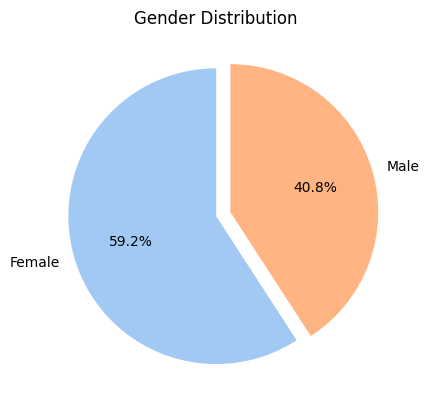

In [ ]:
# 성별 분포 - 비율 확인
plt.pie(df['Gender'].value_counts(), labels=df['Gender'].value_counts().index
        , autopct='%1.1f%%', startangle=90, explode=[0, 0.1], colors=sns.color_palette('pastel'))
plt.title('Gender Distribution')
plt.show()

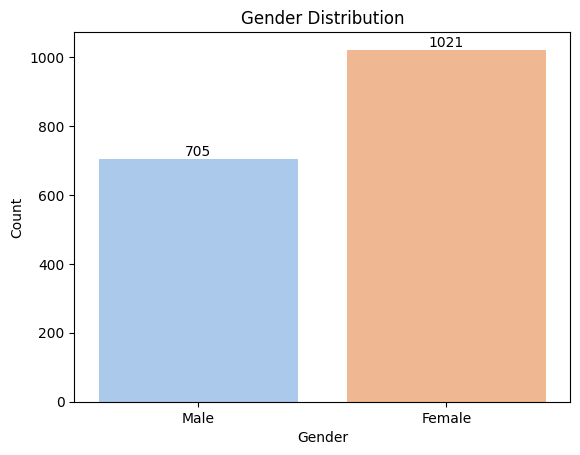

In [ ]:
# 성별 분포 - 카운트 확인
sns.countplot(data=df, x='Gender', palette='pastel')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), int(p.get_height()), ha='center', va='bottom')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

- 여성은 1021명(59.2%), 남성은 705명(40.8%)이다

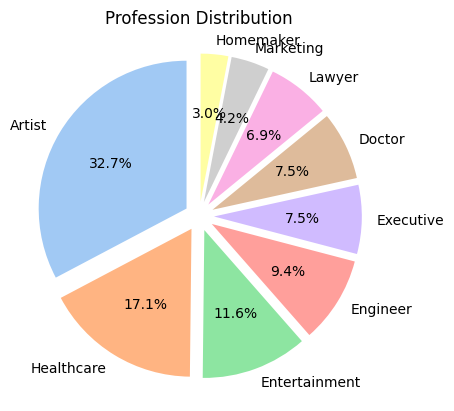

In [ ]:
# 직업 분포 - 비율 확인
plt.pie(df['Profession'].value_counts(), labels=df['Profession'].value_counts().index,
        autopct='%1.1f%%', startangle=90, explode=[0.1] * len(df['Profession'].value_counts())
        , colors=sns.color_palette('pastel'))
plt.title('Profession Distribution')
plt.show()

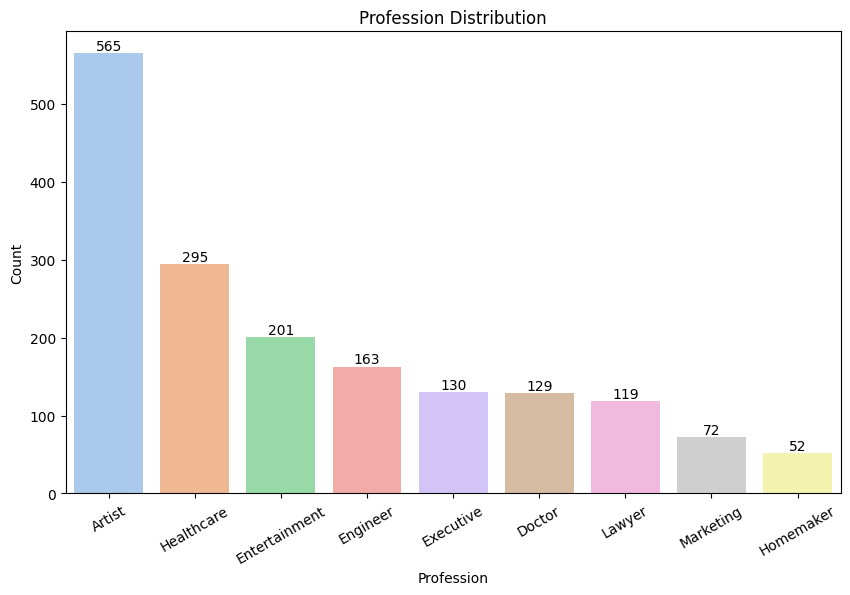

In [ ]:
# 직업 분포 - 카운트 확인
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Profession', order=df['Profession'].value_counts().index, palette='pastel')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), int(p.get_height()), ha='center', va='bottom')

plt.title('Profession Distribution')
plt.xlabel('Profession')
plt.xticks(rotation=30)
plt.ylabel('Count')
plt.show()

- Artist(32.7%)가 많은 비율을 차지하는 것으로 나타났는데 결측값을 최빈값으로 대체한 영향도 있을 것으로 추측된다
- Artist(565명) 다음으로는 Healthcare(295명), Entertainment(201명), Engineer(163명)순으로 많았다
- Homemaker가 52명으로 제일 적었다

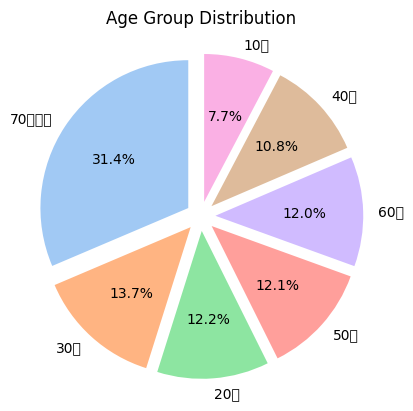

In [ ]:
# Age_group - 비율 확인
plt.pie(df['Age_Group'].value_counts(), labels=df['Age_Group'].value_counts().index,
        autopct='%1.1f%%', startangle=90, explode=[0.1] * len(df['Age_Group'].value_counts())
        , colors=sns.color_palette('pastel'))
plt.title('Age Group Distribution')
plt.show()

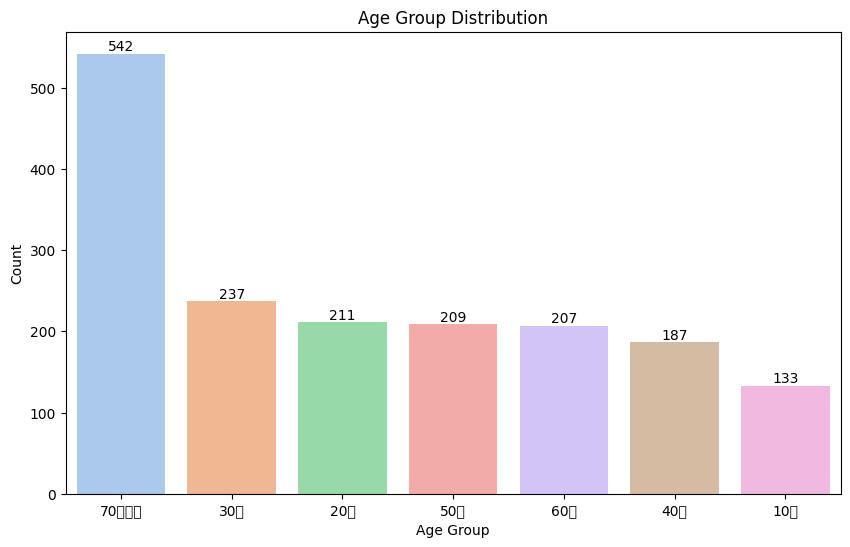

In [ ]:
# Age_group - 카운트 확인
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Age_Group', order=df['Age_Group'].value_counts().index, palette='pastel')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), int(p.get_height()), ha='center', va='bottom')

plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

- 70대 이상이 542명(31.4%)로 제일 많았고 그외 연령은 다 고르게 분포되어 있다
- 이 데이터셋은 15세 이상부터 90대 까지 전 연령대가 비슷하게 분포하는데 이것을 연령대로 구간화 한 영향으로 보인다

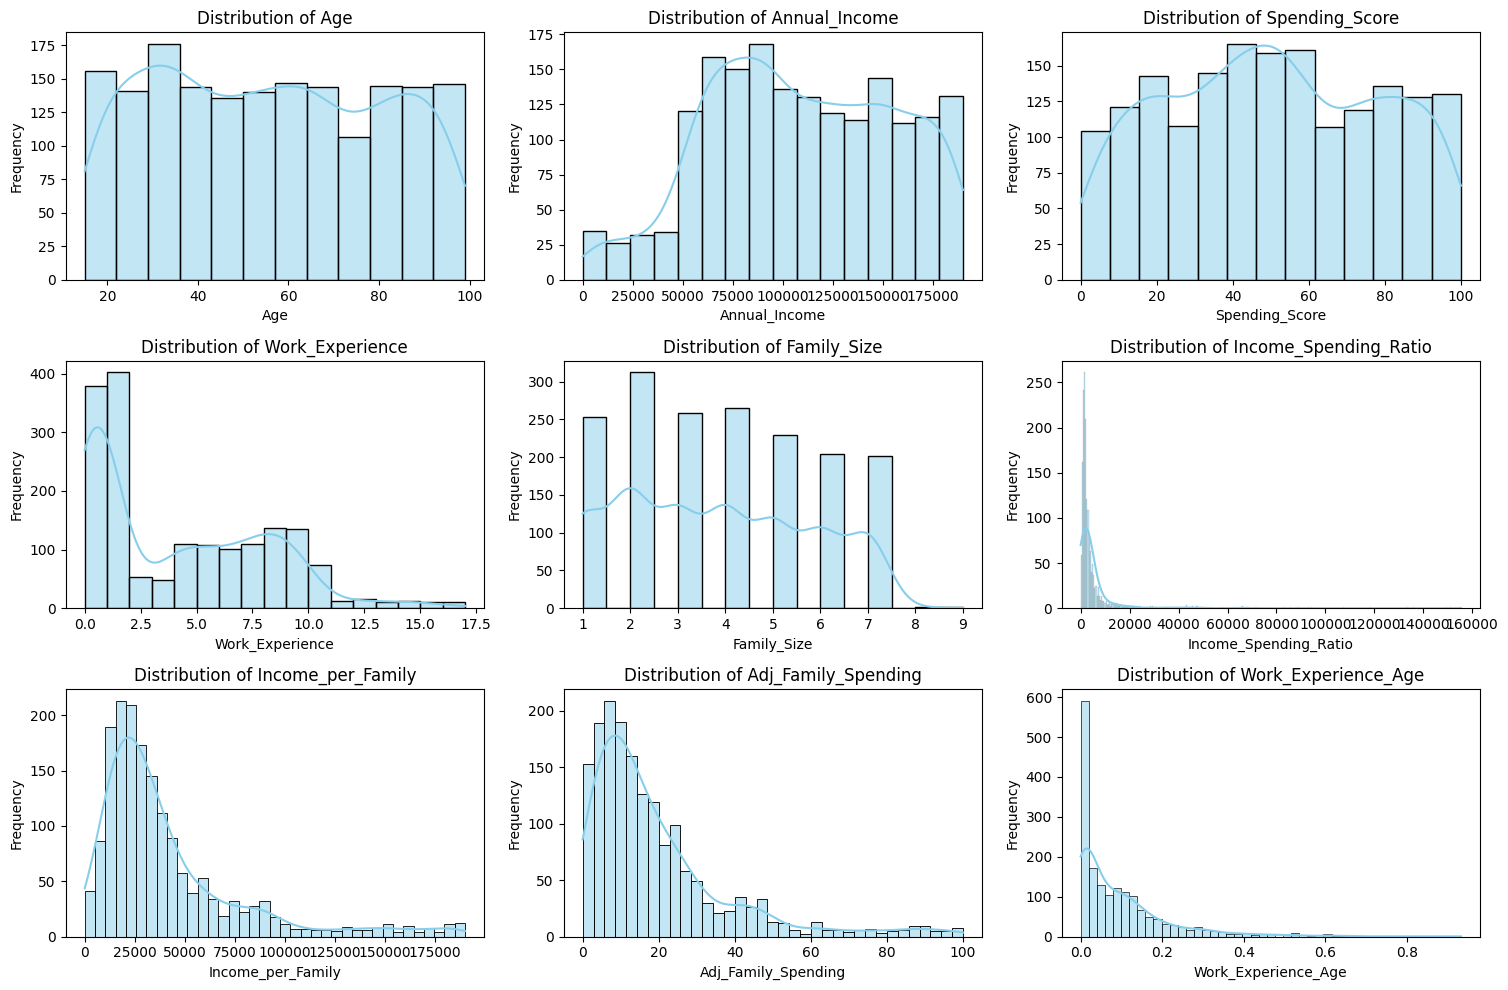

In [ ]:
# 연속형 변수 시각화
numerical_cols = ['Age', 'Annual_Income', 'Spending_Score', 'Work_Experience', 'Family_Size'
                , 'Income_Spending_Ratio', 'Income_per_Family', 'Adj_Family_Spending', 'Work_Experience_Age']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

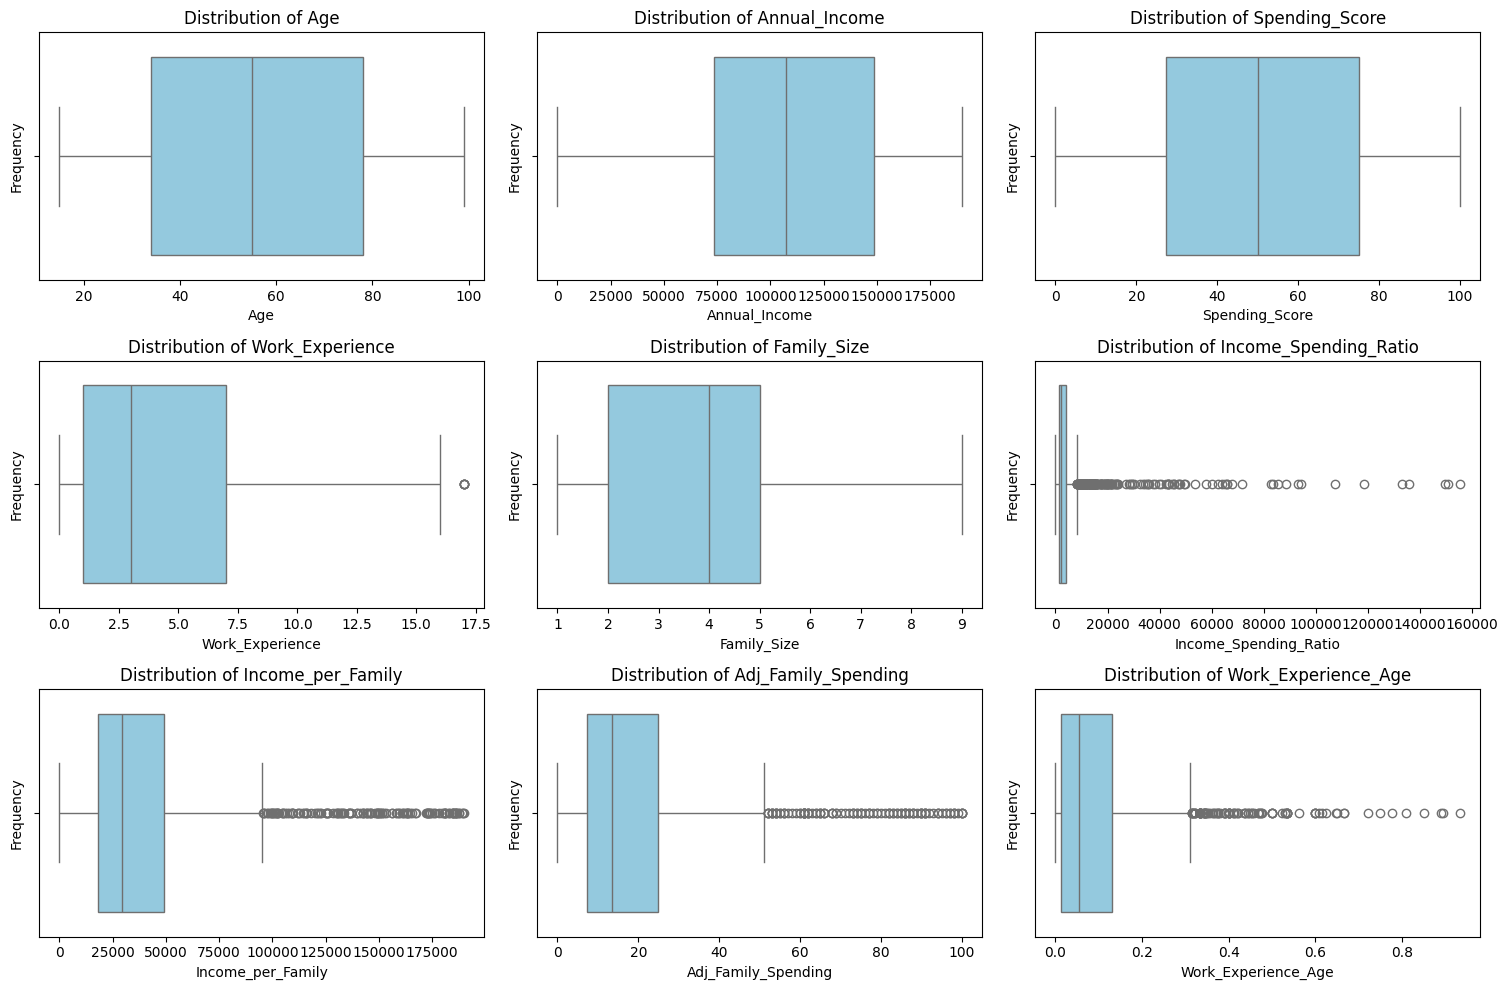

In [ ]:
# 박스플롯으로 이상치 확인
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x=col, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 피처엔지니어링

In [ ]:
# 범주형 변수 인코딩
le = LabelEncoder()

df_scaled = df.copy()

categorical_cols = ['Gender', 'Profession', 'Age_Group']
for col in categorical_cols:
    df_scaled[col] = le.fit_transform(df_scaled[col])

In [ ]:
# 연속형 변수 중 무한 값을 NaN값으로 대체
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN값을 중앙 값으로 대체 -> 이상치의 영향을 덜 받기 위함
for col in df.select_dtypes(include=np.number).columns: # 숫자형 컬럼만 선택
    df[col].fillna(df[col].median(), inplace=True)

# 연속형 변수 스케일링
scaler = StandardScaler()

numerical_cols = ['Age', 'Annual_Income', 'Spending_Score', 'Work_Experience', 'Family_Size'
                , 'Income_Spending_Ratio', 'Income_per_Family', 'Adj_Family_Spending', 'Work_Experience_Age']
for col in numerical_cols:
    df_scaled[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_scaled[col].fillna(df_scaled[col].median(), inplace=True)
    df_scaled[col] = scaler.fit_transform(df_scaled[[col]])

In [ ]:
df_scaled.head()

CustomerID  Gender       Age  Annual_Income  Spending_Score  Profession  \
0           1       1 -1.488793      -2.043830       -0.415255           5   
1           2       1 -1.407551      -1.610724        1.093121           2   
2           3       0 -1.448172      -0.506305       -1.600408           2   
3           4       0 -1.326308      -1.090998        0.949466           7   
4           5       0 -1.001339      -1.545758       -0.379341           3   

   Work_Experience  Family_Size  Income_Spending_Ratio  Income_per_Family  \
0        -0.783769     0.113922              -0.386845          -1.016742   
1        -0.270281    -0.396802              -0.382974          -0.804412   
2        -0.783769    -1.418249               0.750332           1.189261   
3        -1.040513    -0.907525              -0.355734          -0.326109   
4        -0.527025     1.135368              -0.340752          -0.947455   

   Adj_Family_Spending  Work_Experience_Age  Age_Group  
0            -0.513485            -0.346783          0  
1             0.395142             0.388224          1  
2            -0.711013            -0.368220          0  
3             1.000894            -0.775536          1  
4            -0.675897            -0.249967          2

# 상관관계 확인

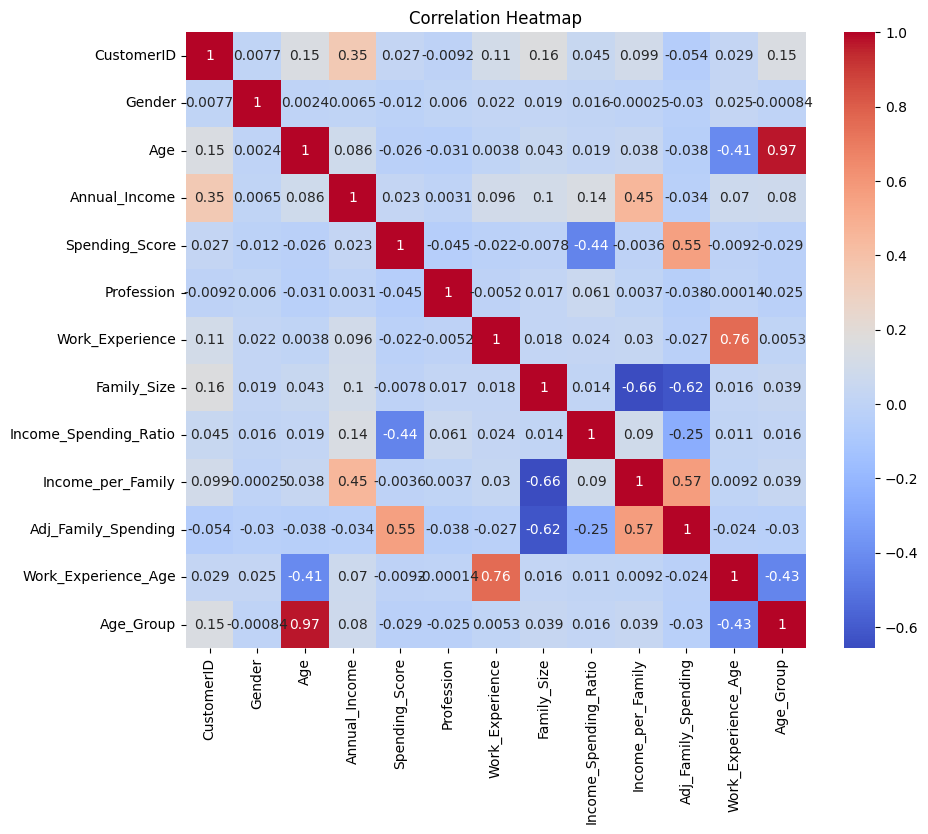

In [ ]:
# 상관관계 확인
corr = df_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

- 상관관계 확인 결과, 각 변수 간 눈에 띄는 상관관계가 없는 것으로 보인다
- 비교적 값이 높은 것들은 기존 변수와 기존 변수를 활용해 생성한 파생 변수들간의 관계이다


# PCA(주성분 분석)를 통한 차원 축소

- 해당 데이터 셋은 다차원(컬럼 13개) 데이터 셋이므로 클러스터링 성능을 향상  시키기위해 PCA를 통한 차원 축소를 진행한다

In [ ]:
# 3차원으로 축소
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled)

# K-Means 클러스터링

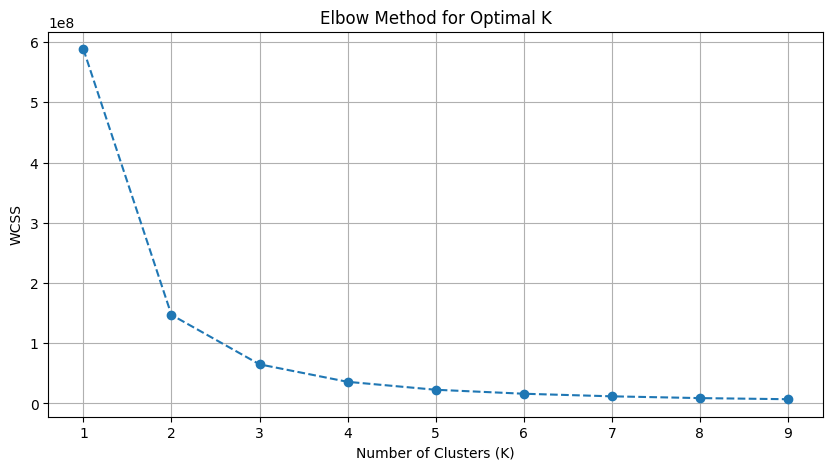

In [ ]:
# 엘보우 메소드로 최적의 k 찾기
wcss = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    wcss.append(kmeans.inertia_)  # inertia_는 WCSS 값

plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.xticks(range(1, 10))
plt.grid(True)
plt.show()

In [ ]:
# K-means 클러스터링을 적용할 데이터프레임 생성
df_kmeans = df_scaled.copy()

# 모델 학습 및 예측
kmeans = KMeans(n_clusters=3, random_state=42)          # 최적의 k는 3
df_kmeans['Cluster'] = kmeans.fit_predict(pca_result)

# 결과 확인
df_kmeans.head()

CustomerID  Gender       Age  Annual_Income  Spending_Score  Profession  \
0           1       1 -1.488793      -2.043830       -0.415255           5   
1           2       1 -1.407551      -1.610724        1.093121           2   
2           3       0 -1.448172      -0.506305       -1.600408           2   
3           4       0 -1.326308      -1.090998        0.949466           7   
4           5       0 -1.001339      -1.545758       -0.379341           3   

   Work_Experience  Family_Size  Income_Spending_Ratio  Income_per_Family  \
0        -0.783769     0.113922              -0.386845          -1.016742   
1        -0.270281    -0.396802              -0.382974          -0.804412   
2        -0.783769    -1.418249               0.750332           1.189261   
3        -1.040513    -0.907525              -0.355734          -0.326109   
4        -0.527025     1.135368              -0.340752          -0.947455   

   Adj_Family_Spending  Work_Experience_Age  Age_Group  Cluster  
0            -0.513485            -0.346783          0        2  
1             0.395142             0.388224          1        2  
2            -0.711013            -0.368220          0        2  
3             1.000894            -0.775536          1        2  
4            -0.675897            -0.249967          2        2

In [ ]:
# 클러스터별 명칭 수정
df_kmeans['Cluster'] = df_kmeans['Cluster'].map({0: 'A', 1: 'B', 2: 'C'})

# KMeans Cluster 기준으로 분포 확인
df_kmeans.groupby('Cluster').describe()

CustomerID                                                             \
             count         mean         std     min      25%     50%      75%   
Cluster                                                                         
A            574.0   995.156794  193.936424   656.0   826.75   998.5  1161.50   
B            566.0  1664.367491  195.497159  1329.0  1492.25  1664.0  1836.75   
C            586.0   316.476109  193.018303     1.0   147.25   305.5   486.75   

                Gender            ... Work_Experience_Age           Age_Group  \
            max  count      mean  ...                 75%       max     count   
Cluster                           ...                                           
A        1328.0  574.0  0.405923  ...            0.097284  4.655344     574.0   
B        2000.0  566.0  0.416961  ...            0.400873  5.560490     566.0   
C         654.0  586.0  0.402730  ...            0.406407  6.827696     586.0   

                                                      
             mean       std  min  25%  50%  75%  max  
Cluster                                               
A        3.864111  2.075117  0.0  2.0  4.0  6.0  6.0  
B        3.908127  2.056383  0.0  2.0  4.0  6.0  6.0  
C        3.308874  2.019179  0.0  2.0  3.0  5.0  6.0  

[3 rows x 104 columns]

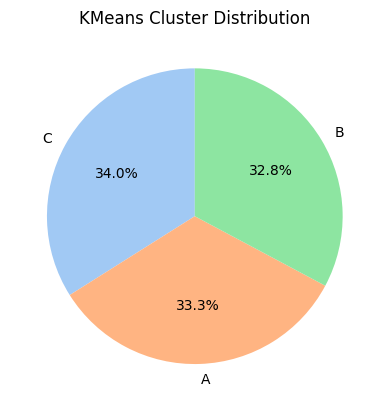

In [ ]:
# 클러스터별 구성 비율 시각화
plt.pie(df_kmeans['Cluster'].value_counts(), labels=df_kmeans['Cluster'].value_counts().index
        , autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('KMeans Cluster Distribution')
plt.show()

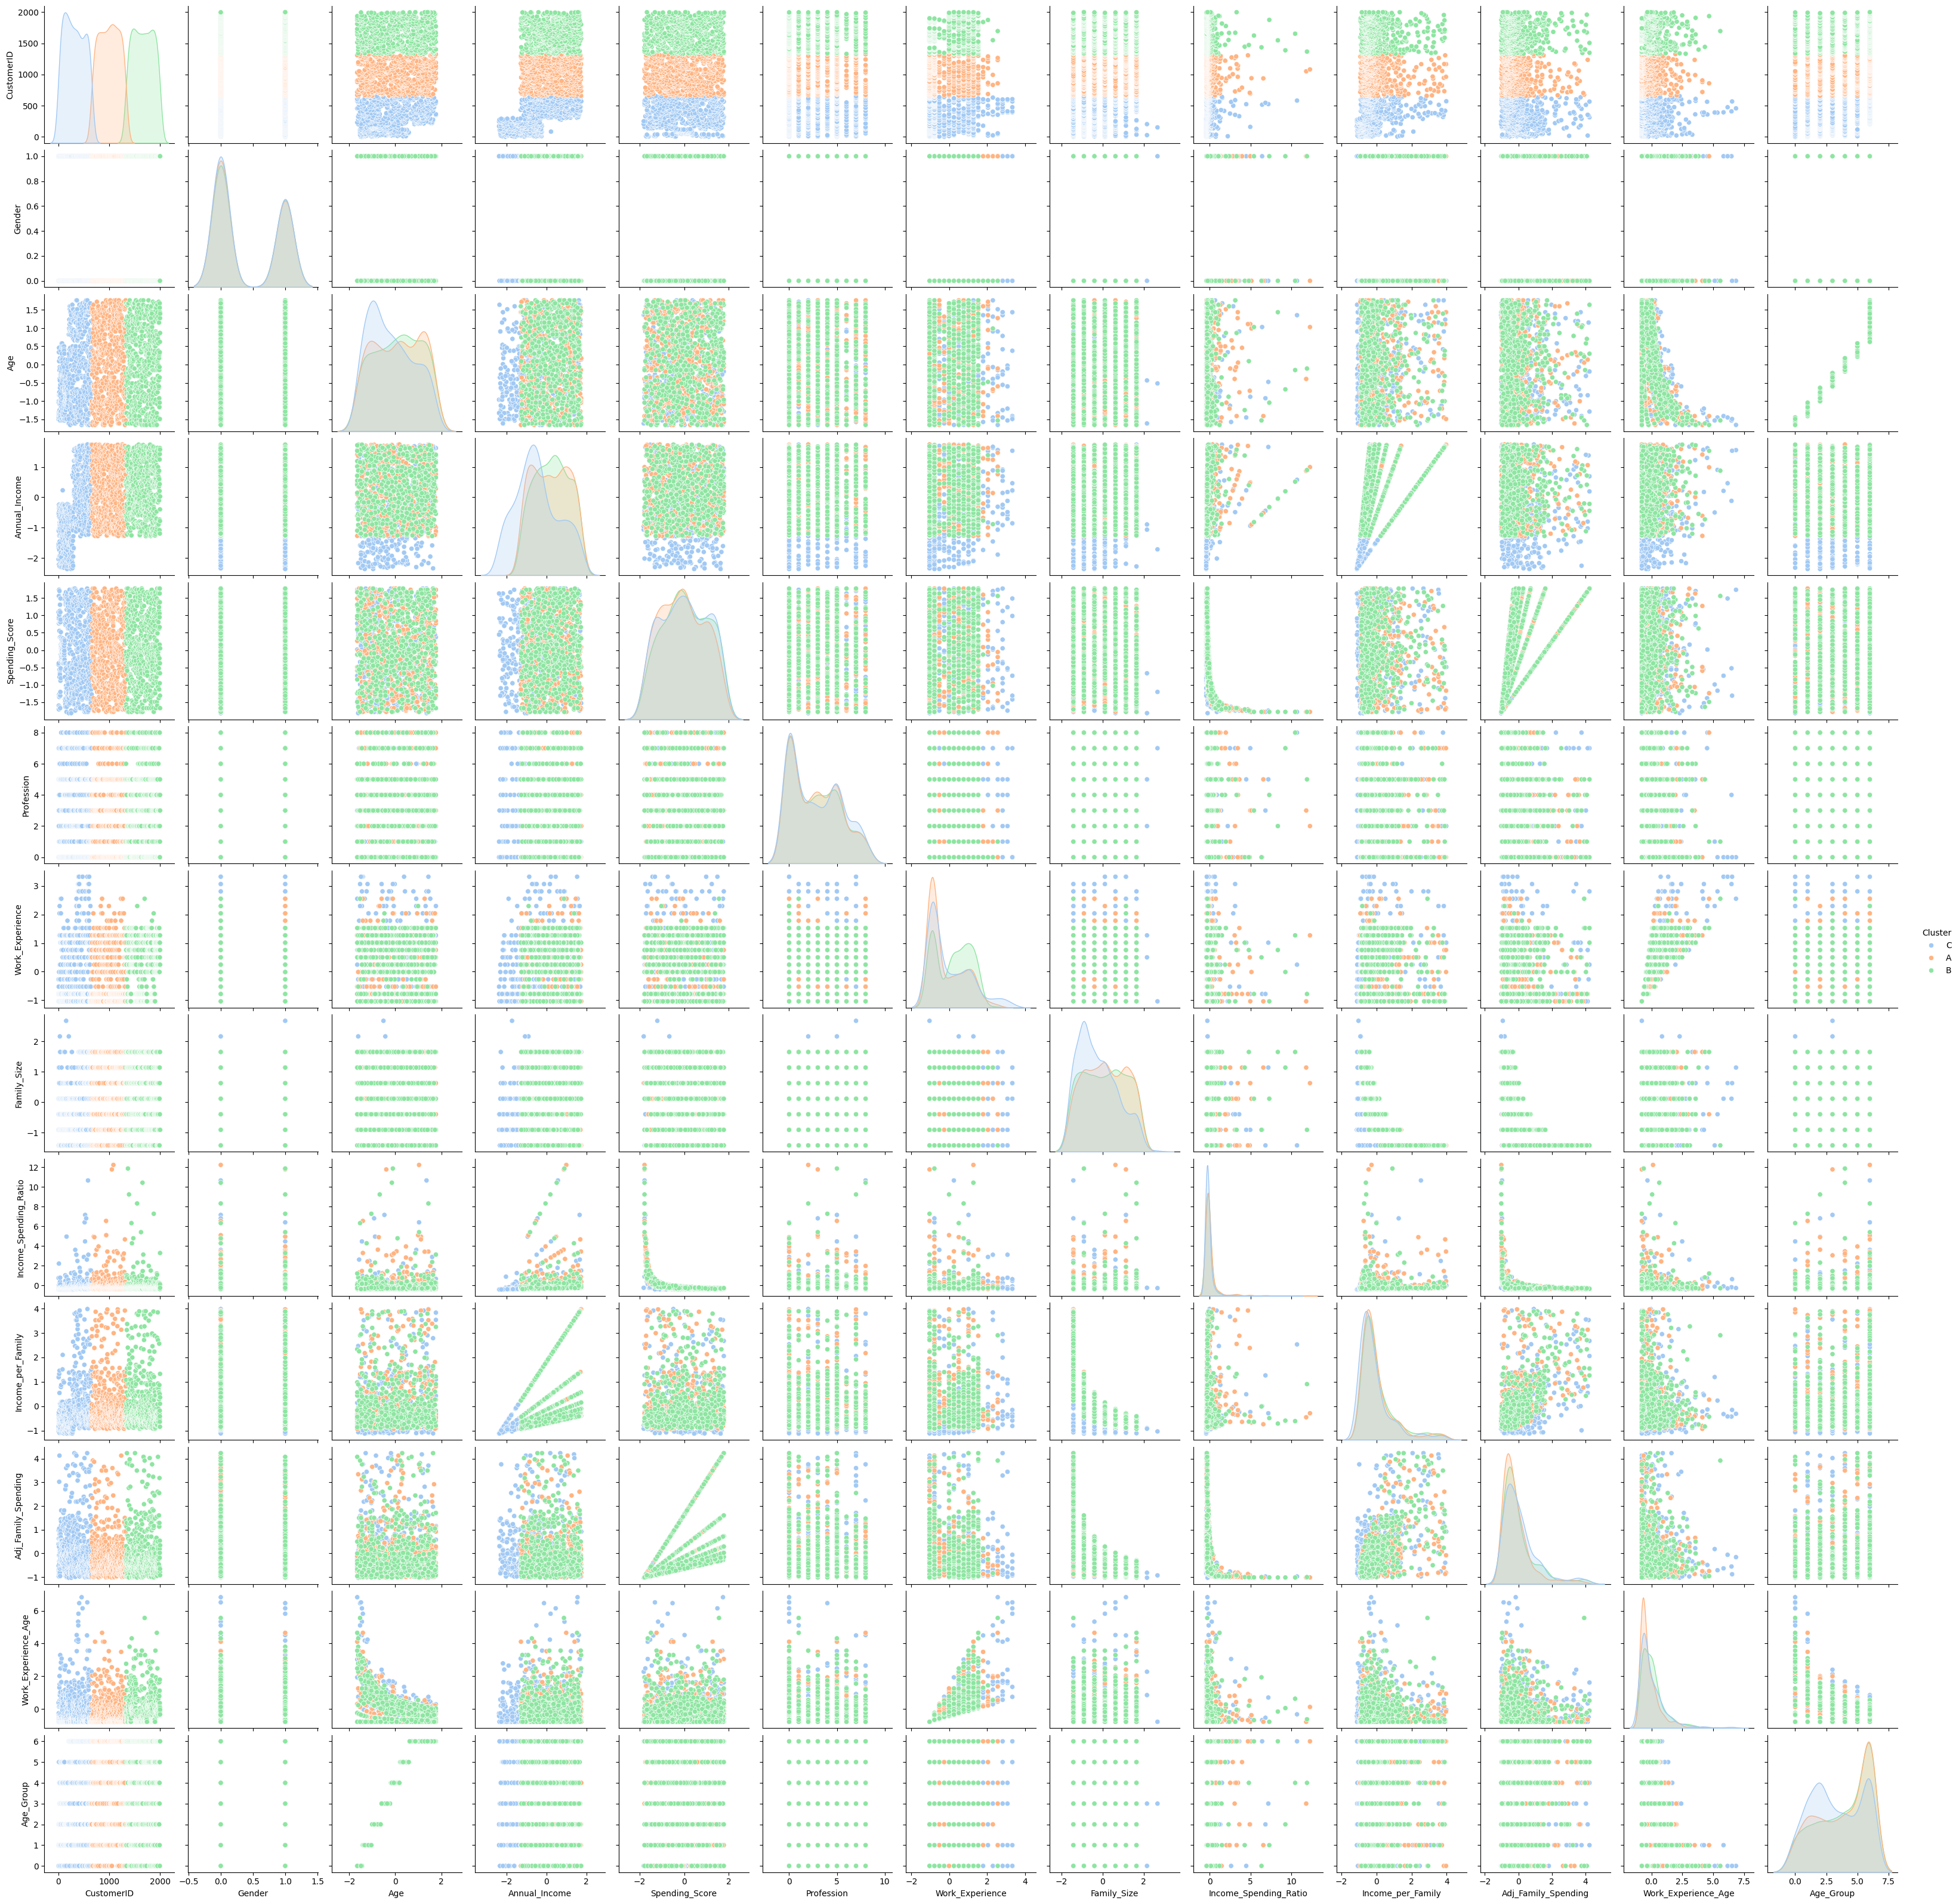

In [ ]:
# 컬럼 간 관계 시각화
plt.axes = sns.pairplot(df_kmeans, hue='Cluster', palette='pastel')
plt.show()

In [ ]:
silhouette_kmeans = silhouette_score(pca_result, df_kmeans['Cluster'])
print(f'KMeans 클러스터링 결과 silhouette Score: {silhouette_kmeans:.2f}')

KMeans 클러스터링 결과 silhouette Score: 0.59


[K-Means 클러스터링 결과]

- 3개로 군집이 형성되었고 각 군집의 구성비율은 33% 내외로 고르게 분포한다
- 실루엣 계수는 0.59이다
    - 실루엣 계수는 값이 1에 가까울수록 군집화가 잘 이루어졌으며 0.5~0.7일 경우 양호한 군집화로 군집이 비교적 잘 분리되었고, 각 군집 내 데이터의 응집도가 높다고 평가한다

# 고객세분화

In [ ]:
# 클러스터 레이블을 원본데이터(df)에 추가
df['Cluster'] = df_kmeans['Cluster']

In [ ]:
# 클러스터별 분포 확인
df.groupby('Cluster').describe().T

Cluster                             A            B           C
CustomerID          count  574.000000   566.000000  586.000000
                    mean   995.156794  1664.367491  316.476109
                    std    193.936424   195.497159  193.018303
                    min    656.000000  1329.000000    1.000000
                    25%    826.750000  1492.250000  147.250000
...                               ...          ...         ...
Work_Experience_Age min      0.000000     0.000000    0.000000
                    25%      0.000000     0.016737    0.011765
                    50%      0.031754     0.081794    0.047247
                    75%      0.107143     0.144410    0.145089
                    max      0.666667     0.777778    0.933333

[80 rows x 3 columns]

In [ ]:
df.groupby('Cluster').describe()

CustomerID                                                             \
             count         mean         std     min      25%     50%      75%   
Cluster                                                                         
A            574.0   995.156794  193.936424   656.0   826.75   998.5  1161.50   
B            566.0  1664.367491  195.497159  1329.0  1492.25  1664.0  1836.75   
C            586.0   316.476109  193.018303     1.0   147.25   305.5   486.75   

                   Age             ... Adj_Family_Spending         \
            max  count       mean  ...                 75%    max   
Cluster                            ...                              
A        1328.0  574.0  57.958188  ...               21.75   98.0   
B        2000.0  566.0  58.084806  ...               24.75  100.0   
C         654.0  586.0  51.039249  ...               28.00  100.0   

        Work_Experience_Age                                               \
                      count      mean       std  min       25%       50%   
Cluster                                                                    
A                     574.0  0.073966  0.103178  0.0  0.000000  0.031754   
B                     566.0  0.109141  0.117340  0.0  0.016737  0.081794   
C                     586.0  0.102536  0.141597  0.0  0.011765  0.047247   

                             
              75%       max  
Cluster                      
A        0.107143  0.666667  
B        0.144410  0.777778  
C        0.145089  0.933333  

[3 rows x 80 columns]

In [ ]:
# Cluster A 분포
df[df['Cluster'] == 'A'].describe(include='all').T

count unique     top freq           mean           std  \
CustomerID             574.0    NaN     NaN  NaN     995.156794    193.936424   
Gender                   574      2  Female  341            NaN           NaN   
Age                    574.0    NaN     NaN  NaN      57.958188     25.063514   
Annual_Income          574.0    NaN     NaN  NaN  119233.905923  41323.835704   
Spending_Score         574.0    NaN     NaN  NaN      48.454704     27.390025   
Profession               574      9  Artist  186            NaN           NaN   
Work_Experience        574.0    NaN     NaN  NaN       3.303136      3.628291   
Family_Size            574.0    NaN     NaN  NaN       4.045296      1.947309   
Income_Spending_Ratio  574.0    NaN     NaN  NaN    5903.424785  12890.154671   
Income_per_Family      574.0    NaN     NaN  NaN   42606.435499  37181.903621   
Adj_Family_Spending    574.0    NaN     NaN  NaN      16.856732     16.780526   
Work_Experience_Age    574.0    NaN     NaN  NaN       0.073966      0.103178   
Age_Group                574      7   70대이상  203            NaN           NaN   
Cluster                  574      1       A  574            NaN           NaN   

                               min          25%          50%           75%  \
CustomerID                   656.0       826.75        998.5        1161.5   
Gender                         NaN          NaN          NaN           NaN   
Age                           15.0        35.25         59.0          81.0   
Annual_Income              50250.0     81748.25     118116.0     155812.25   
Spending_Score                 1.0         25.0         48.0          71.0   
Profession                     NaN          NaN          NaN           NaN   
Work_Experience                0.0          0.0          1.0           6.0   
Family_Size                    1.0          2.0          4.0           6.0   
Income_Spending_Ratio   538.885417  1585.054688  2503.977564   4813.880769   
Income_per_Family      7221.428571     19387.75      30421.3  50017.583333   
Adj_Family_Spending       0.166667          5.8         12.0         21.75   
Work_Experience_Age            0.0          0.0     0.031754      0.107143   
Age_Group                      NaN          NaN          NaN           NaN   
Cluster                        NaN          NaN          NaN           NaN   

                            max  
CustomerID               1328.0  
Gender                      NaN  
Age                        99.0  
Annual_Income          189945.0  
Spending_Score            100.0  
Profession                  NaN  
Work_Experience            14.0  
Family_Size                 7.0  
Income_Spending_Ratio  155396.0  
Income_per_Family      189498.0  
Adj_Family_Spending        98.0  
Work_Experience_Age    0.666667  
Age_Group                   NaN  
Cluster                     NaN

In [ ]:
# Cluster B 분포
df[df['Cluster'] == 'B'].describe(include='all').T

count unique     top freq           mean           std  \
CustomerID             566.0    NaN     NaN  NaN    1664.367491    195.497159   
Gender                   566      2  Female  330            NaN           NaN   
Age                    566.0    NaN     NaN  NaN      58.084806     24.590664   
Annual_Income          566.0    NaN     NaN  NaN  121486.206714   39099.16633   
Spending_Score         566.0    NaN     NaN  NaN      52.404594     27.686051   
Profession               566      9  Artist  184            NaN           NaN   
Work_Experience        566.0    NaN     NaN  NaN       4.830389      3.525813   
Family_Size            566.0    NaN     NaN  NaN       3.980565      2.017966   
Income_Spending_Ratio  566.0    NaN     NaN  NaN    5328.122388  13285.835161   
Income_per_Family      566.0    NaN     NaN  NaN   45141.743433  38166.792856   
Adj_Family_Spending    566.0    NaN     NaN  NaN      19.795213     19.585006   
Work_Experience_Age    566.0    NaN     NaN  NaN       0.109141       0.11734   
Age_Group                566      7   70대이상  199            NaN           NaN   
Cluster                  566      1       B  566            NaN           NaN   

                               min           25%         50%          75%  \
CustomerID                  1329.0       1492.25      1664.0      1836.75   
Gender                         NaN           NaN         NaN          NaN   
Age                           15.0         37.25        59.0         79.0   
Annual_Income              50223.0       89774.0    123155.0     152318.0   
Spending_Score                 1.0          31.0        51.0         76.0   
Profession                     NaN           NaN         NaN          NaN   
Work_Experience                0.0           1.0         5.0          8.0   
Family_Size                    1.0           2.0         4.0          6.0   
Income_Spending_Ratio   552.082474   1575.937458  2309.77961  3947.175294   
Income_per_Family      7314.142857  20809.511905     31348.6     55511.25   
Adj_Family_Spending       0.142857      7.571429        13.4        24.75   
Work_Experience_Age            0.0      0.016737    0.081794      0.14441   
Age_Group                      NaN           NaN         NaN          NaN   
Cluster                        NaN           NaN         NaN          NaN   

                            max  
CustomerID               2000.0  
Gender                      NaN  
Age                        99.0  
Annual_Income          189689.0  
Spending_Score            100.0  
Profession                  NaN  
Work_Experience            14.0  
Family_Size                 7.0  
Income_Spending_Ratio  150925.0  
Income_per_Family      186673.0  
Adj_Family_Spending       100.0  
Work_Experience_Age    0.777778  
Age_Group                   NaN  
Cluster                     NaN

In [ ]:
# Cluster C 분포
df[df['Cluster'] == 'C'].describe(include='all').T

count unique     top freq          mean           std  \
CustomerID             586.0    NaN     NaN  NaN    316.476109    193.018303   
Gender                   586      2  Female  350           NaN           NaN   
Age                    586.0    NaN     NaN  NaN     51.039249     23.589585   
Annual_Income          586.0    NaN     NaN  NaN  88035.551195  49487.393241   
Spending_Score         586.0    NaN     NaN  NaN     50.848123     28.366451   
Profession               586      9  Artist  195           NaN           NaN   
Work_Experience        586.0    NaN     NaN  NaN      4.035836      4.326868   
Family_Size            586.0    NaN     NaN  NaN      3.317406      1.828064   
Income_Spending_Ratio  586.0    NaN     NaN  NaN   4180.156847  10447.840276   
Income_per_Family      586.0    NaN     NaN  NaN  37366.637283  36185.708143   
Adj_Family_Spending    586.0    NaN     NaN  NaN     21.799152     20.121703   
Work_Experience_Age    586.0    NaN     NaN  NaN      0.102536      0.141597   
Age_Group                586      7   70대이상  140           NaN           NaN   
Cluster                  586      1       C  586           NaN           NaN   

                        min         25%           50%          75%       max  
CustomerID              1.0      147.25         305.5       486.75     654.0  
Gender                  NaN         NaN           NaN          NaN       NaN  
Age                    15.0        32.0          48.0        68.75      99.0  
Annual_Income           0.0     52803.5       83779.5     121189.5  189974.0  
Spending_Score          0.0        28.0          51.0         75.0     100.0  
Profession              NaN         NaN           NaN          NaN       NaN  
Work_Experience         0.0         1.0           2.0          7.0      17.0  
Family_Size             1.0         2.0           3.0          5.0       9.0  
Income_Spending_Ratio   0.0  916.835616   1666.460317  3399.096429  136037.0  
Income_per_Family       0.0  14495.4875  26333.333333      44000.0  189974.0  
Adj_Family_Spending     0.0         8.0     16.333333         28.0     100.0  
Work_Experience_Age     0.0    0.011765      0.047247     0.145089  0.933333  
Age_Group               NaN         NaN           NaN          NaN       NaN  
Cluster                 NaN         NaN           NaN          NaN       NaN

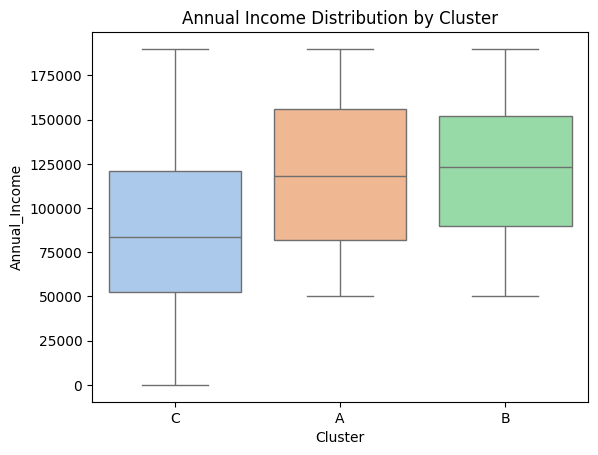

In [ ]:
# Annual_Income과 Cluster 관계 시각화
sns.boxplot(data=df, x='Cluster', y='Annual_Income', palette='pastel')
plt.title('Annual Income Distribution by Cluster')
plt.show()

# 결론

**[파생변수 유무에 따른 차이점]**

- 파생변수를 생성한 후 클러스터링을 진행했지만 파생변수를 생성하지 않고 진행했을 때와 큰 차이는 없는 것으로 나타났다
- 고객 세분화를 위한 클러스터링을 진행하기 위해서는 충분한 데이터 볼륨이 확보되어야 하며 실제 데이터 셋이나 실제와 유사한 데이터 셋을 확보하는 것이 중요함을 알 수 있다.

**[요약]**

- 성별: 여성은 1021명(59.2%), 남성은 705명(40.8%)이다
- 직업
    - Artist(32.7%)가 많은 비율을 차지하는 것으로 나타났는데 결측값을 최빈값으로 대체한 영향도 있을 것으로 추측된다
    - Artist(565명) 다음으로는 Healthcare(295명), Entertainment(201명), Engineer(163명)순으로 많고, Homemaker가 52명으로 제일 적다
- 연령: 전 연령대가 고르게 분포하며 그 중 30대가 제일 많고 70대가 제일 적다
- 연간 소득: 50000달러 이상에서 고르게 분포한다
- 소비 점수: 40 ~ 60점에 주로 분포하며 전체적으로 고르게 분포한다
- 근무 연수: 0 ~ 2.5년인 경우가 제일 많고 4 ~ 11년에서 고르게 분포한다
- 가족 수: 2명인 경우가 제일 많고 1 ~ 7명에서 고르게 분포한다

---

**[전략 제안]**

- 타겟 층
    - 성별: 여성
    - 직업군: Artist, Healthcare, Entertainment, Engineer
    - 연령: 30대
    - 소비 점수: 소비 점수가 중간인 경우가 많으므로 전체 고객의 소비 점수를 올릴 수 있는 방안 모색
    - 근무 연수: 근무 연수가 2.5년 이하
    - 가족 수: 가족 수가 2명 내외인 고객

---

**[고객 세분화 결과]**

- 최종 군집 개수는 **`3개`**이며 고객 그룹을 각 **`A, B, C`**로 나누었다.
- 비교적 세분화가 잘 된 그룹은 **`C`**이며, A와 B는 데이터 분포가 유사하다.
- 차이가 구분되는 컬럼은 **`Annual_Income`**으로 다른 변수들간의 차이가 확연히 구별된다.

---

**[데이터 세트의 한계]**

- 클러스터별 분포 확인을 보면 고객 그룹이 `CustomerID` 컬럼 기준으로 순서대로 나뉘어짐을 알 수 있다. 중간에 비어있는 번호는 삭제된 15세미만 데이터의 `CustomerID` 값으로 보인다.

|고객 그룹|최소||최대|
|--|--|--|--|
|A| 656| ~ |1328|
|B| 1329| ~ |2000|

- 그럼에도 `Annual_Income`값의 범위가 C그룹과 A, B그룹 간에 구별되는 이유는 데이터 세트가 실제 데이터를 기반으로 만들어진 것이 아닌 임의로 만들어진 데이터 세트이기 때문으로 보인다
- 데이터 세트의 볼륨이 작고 이상적인 구조인 경우 클러스터링이 비효율적일 수 있음을 의미한다
